In [1]:
import gym
import minihack
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import sys
from io import StringIO
from minihack import LevelGenerator
from minihack.envs.room import MiniHackRoom15x15
from minihack.envs.corridor import MiniHackCorridor
from minihack.envs.mazewalk import MiniHackMazeWalk9x9


In [2]:
def render_des_file(des_file):
    env = gym.make('MiniHack-Skill-Custom-v0',
               character="sam-hum-neu-mal",
               observation_keys=('screen_descriptions','inv_strs','blstats','message','pixel'),
               des_file=des_file)

    obs = env.reset()
    env.render()
    plt.imshow(obs['pixel'][0:1000, 0:1000])

Now we define the function that creates the store des files, the map is default but the items are randomly generated with this logic:  
-A Healing Item (healing potion) is always present.  
-Two to five items are present on the right, these are always different (sword and bow, bow and armor, sword and armor, sword and best sword)  
-The cost of the items depends on the others respecting this scale : potion->arrows->weapon->armor  
-The weapon and arrows will change the character's attack by making more enemies beatable, the armor will increase the maximum healthiness, the potion will cure the healthiness without exceeding the limit.  
  
-Available items are:  
'healing' (life potion).
      
-Available swords are :  
 'bullwhip'
 'stiletto'  
 'long sword'  
 'morning star'  
 'katana'  
  
-Possible arrows are:   
 'orcish arrow'  
 'silver arrow'  
 'arrow'  
 'elven arrow'  
 'ya'  
  
-The possible armors are :  
 'scale mail'  
 'bronze plate mail'  
 'dwarvish mithril-coat'  
 'elven mithril-coat'  
 'chain mail'  
  
All items are ordered from weakest to strongest.

In [3]:
AVAIABLE_OBJECTS=[
'healing',
]

#Armi disponibili dalla più scarsa alla più forte
AVAIABLE_ARROWS=[
'orcish arrow',
'silver arrow',
'arrow',
'elven arrow',
'ya'
]

AVAIABLE_WEAPONS=[
'bullwhip',
'stiletto',
'long sword',
'morning star',
'katana',
]

AVAIABLE_ARMORS=[
'scale mail',
'bronze plate mail', 
'dwarvish mithril-coat',
'elven mithril-coat',
'chain mail'  
]

SYMBOLS=[
'!', #healing potion
')', #arrows
')', #weapons
'[', #armor
]

avaiableitems=['HEALING','ARROWS','WEAPON','ARMOR']


We define the function that adds a random object (dependent on the seed entered) to the given location.  
-In higher levels better weapons are spawned.
-The items offered are equal but with more quality if all items are already spawned (only in five case)



In [4]:
def addobject(lvl: LevelGenerator, seed:int, posx:int ,posy:int,others: [str]):
    #se gli altri sono frecce, arma e armatura, cerco di spawnare un'altra entità di qualità differente
    levelnumber =math.floor(seed/200)
    quality=levelnumber-1
    remainingitems=['HEALING','ARROWS','WEAPON','ARMOR']
    #gestione del caso (ci sono già altri item di questo tipo nello shop)
    for i in others:
        remainingitems.pop(remainingitems.index(i))
    if remainingitems.__len__()==0:
        remainingitems=['HEALING','ARROWS','WEAPON','ARMOR']
        if levelnumber==5:
            quality=quality-1
        else: quality=quality+1
    #a questo punto in remaining items ci sono gli item che possono ancora spawnare, devo scegliere
    #in modo pseudo-casuale (dipende dal seed)
    choice=seed%remainingitems.__len__()
    choosen=remainingitems[choice]
    pos=(posx,posy)
    if choosen=='HEALING':
        choosenitem=AVAIABLE_OBJECTS[0]
        choosensymbol=SYMBOLS[0]
        lvl.add_object(name=choosenitem,symbol=choosensymbol,place=pos)

    elif choosen=='ARROWS':
        choosenitem=AVAIABLE_ARROWS[quality]
        choosensymbol=SYMBOLS[1]
        lvl.add_object(name=choosenitem,symbol=choosensymbol,place=(posx,posy))
        lvl.add_object(name=choosenitem,symbol=choosensymbol,place=(posx,posy+1))
        lvl.add_object(name=choosenitem,symbol=choosensymbol,place=(posx,posy+2))

    elif choosen=='WEAPON':
        choosenitem=AVAIABLE_WEAPONS[quality]
        choosensymbol=SYMBOLS[2]
        lvl.add_object(name=choosenitem,symbol=choosensymbol,place=pos)

    else:
        choosenitem=AVAIABLE_ARMORS[quality]
        choosensymbol=SYMBOLS[3]
        lvl.add_object(name=choosenitem,symbol=choosensymbol,place=pos)
        
    return choosen
    

Now we define the funcion that fills the shop with a number of items depending on the level.
Level 1: 3 (80%), 4 (15%) 5 (5%)  
Level 2: 3 (50%), 4 (40%) 5 (10%)  
Level 3: 3 (30%), 4 (50%) 5 (20%)  
Level 4: 3 (20%), 4 (30%) 5 (50%)  
Level 5: 3 (5%), 4 (15%) 5 (80%)  


In [5]:

def fillwithobj(lvl: LevelGenerator,seed: int):
    random.seed(seed)
    levelnumber=math.floor(seed/200)

    if levelnumber==1:
        if seed<=360:
            numitem=3
        elif seed<=390:
            numitem=4
        else: 
            numitem=5

    elif levelnumber==2:
        if seed<=500:
            numitem=3
        elif seed<=580:
            numitem=4
        else: 
            numitem=5

    if levelnumber==3:
        if seed<=660:
            numitem=3
        elif seed<=760:
            numitem=4
        else: 
            numitem=5

    if levelnumber==4:
        if seed<=840:
            numitem=3
        elif seed<=900:
            numitem=4
        else: 
            numitem=5

    if levelnumber==5:
        if seed<=1010:
            numitem=3
        elif seed<=1040:
            numitem=4
        else: 
            numitem=5
    others=[]
    numitem=random.randint(3,5)
    #STARTING ITEMS
    if levelnumber==1:
        lvl.add_object(name='bow',symbol=')',place=(2,6)) #METTI ARCO
        lvl.add_object(name='worm tooth',symbol=')',place=(2,5)) #METTI ARMA INIZIALE
        
    if numitem==3:
        if levelnumber==1:
            others=['HEALING']
            lvl.add_object(name='healing',symbol='!',place=(4,3))
        else:
            others.append(addobject(lvl,seed,4,3,others))
        others.append(addobject(lvl,seed,6,3,others))
        others.append(addobject(lvl,seed,8,3,others))

    elif numitem==4:
        if levelnumber==1:
            others=['HEALING']
            lvl.add_object(name='healing',symbol='!',place=(3,3))
        else:
            others.append(addobject(lvl,seed,3,3,others))
        others.append(addobject(lvl,seed,5,3,others))
        others.append(addobject(lvl,seed,7,3,others))
        others.append(addobject(lvl,seed,9,3,others))

    elif numitem==5:
        if levelnumber==1:
            others=['HEALING']
            lvl.add_object(name='healing',symbol='!',place=(2,3))
        else:
            others.append(addobject(lvl,seed,2,3,others))
        others.append(addobject(lvl,seed,4,3,others))
        others.append(addobject(lvl,seed,6,3,others))
        others.append(addobject(lvl,seed,8,3,others))
        others.append(addobject(lvl,seed,10,3,others))





Finally we define the function that creates the store des file and displays it on the screen.  
The levelnumber is used to generate levels dependent on the floor the character has reached:  
higher floors->better items in the shop and more possible choices (increased probability)


MAZE: "mylevel", ' '
FLAGS:premapped
INIT_MAP: solidfill,' '
GEOMETRY:center,center
MAP
||||||||||||||||  
|...............  
|...........||||  
|...........|     
|...........|     
|...........|     
|...........|     
|||||||||||||     
ENDMAP
REGION:(0,0,18,8),lit,"ordinary"
#LEVEL: 1
#SEED: 204
BRANCH:(1,6,1,6),(0,5,0,5)
MONSTER:"shopkeeper",(6, 1)
DOOR:closed,(12, 1)
OBJECT:(')',"bow"),(2, 6)
OBJECT:(')',"worm tooth"),(2, 5)
OBJECT:('!',"healing"),(3, 3)
OBJECT:(')',"orcish arrow"),(5, 3)
OBJECT:(')',"orcish arrow"),(5, 4)
OBJECT:(')',"orcish arrow"),(5, 5)
OBJECT:(')',"bullwhip"),(7, 3)
OBJECT:('[',"scale mail"),(9, 3)
GOLD: 15,(1, 5)


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
                       

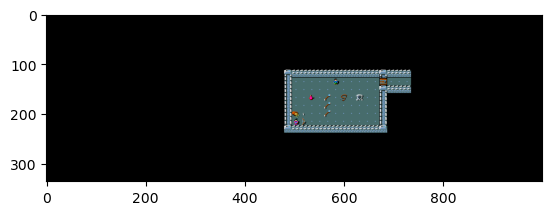

In [6]:

def creashop(levelnumber,startingseed):
    map="""||||||||||||||||
|...............
|...........||||
|...........|    
|...........|    
|...........|   
|...........|     
|||||||||||||"""
    seed=startingseed+200*levelnumber
    lvl=LevelGenerator(map=map,lit=True,flags=['premapped'])
    lvl.add_line("#LEVEL: "+str(levelnumber))
    lvl.add_line("#SEED: "+str(seed))
    lvl.set_start_pos((1,6))
    lvl.add_monster(name='shopkeeper',place=(6,1))
    lvl.add_door("closed", place=(12,1))

    
    fillwithobj(lvl,seed)
    if levelnumber==1:
        startinggold=15 #METTI SOLDI INIZIALI (DA VEDERE ANCORA QUANTI)
        lvl.add_line("GOLD: "+str(startinggold)+",(1, 5)") #PRIMA AMOUNT POI COORDINATE
    
    return lvl.get_des()
 
startingseed=random.randint(0,200)
levelnumber=1
shop=creashop(levelnumber,startingseed)
print(shop)
render_des_file(shop)

In this section we show how we generate the battlefield, the area where our agent will find gold and monsters to defend it.
For the battlefield we chose 5 possible maps for each level with a random generation of monsters and coins.
In each possible level it can happen:  
-Boss room, where there will be only one enemy, the strongest for that level that will defend so many coins.  
-Maze room, the agent will have to perform pathfinding to find the exit and the gold, randomly scattered within the level  
-Room, an open room with enemies and coins spawned nearby  
-Mini boss room: the room shown during the presentation, minibosses defending lots of gold, enemies defending the exit and more enemies defending the gold  
-BONUS ROOM: a very rare room, (1/100) where only coins will be present,  
Next we define the complete list of monsters, in ascending order by difficulty.


In [7]:
MOB=['bat', #Level 1
     'gnome',   #Level 2
     'giant ant',   #Level 3
     'lemure']  #Level 4

MINIBOSS=['dwarf',  #Level 2
          'orc shaman', #Level 3
          'lizard'] #Level 4

BOSS=['gnome lord', #Level 2
      'killer bee', #Level 3 
      'dwarf lord', #Level 4
        'yeti']  #Level 5


In [8]:
minibossmap="""                    ||||||||||||
                    |..........|
                    |.||||||...|
                    |.|........|
                    |.|||||....|
                    |.....|....|
                    |||||||....|
                    |..........|
                    |.|||||....|
                    |.|...|....|
                    |.|...|....|
                    ..|...|....|
                    |||.||||...|
                    |......|...|
                    |......|...|
                    |..........|
                    |......|...|
                    ||||||||||||"""




bossmap="""                          |||||      
                          |...|      
                          |...|      
                    ||||||||.||||    
                    |...|.......|    
                    |...|.......|||||
                    |...|.......|...|
                    ................|
                    |...|.......|...|
                    |...|.......|||||
                    |...|.......|    
                    |||||||||||||"""    


roommap="""                    |||||||||||||||
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    ..............|
                    |||||||||||||||"""

mazebasemap="""                    |||||||||||||||||||||||||
                    |.                     .|
                    |.                     .|
                    |.                     .|
                    ..                     .|
                    |.                     .|
                    |.                     .|
                    |.                     .|
                    |.                     .|
                    |.                     .|
                    |.                     .|
                    |.                     .|
                    |||||||||||||||||||||||||"""

bonusroommap="""                    |||||||
                    |.....|
                    ......|
                    |.....|
                    |||||||
                    
                    
                    
                    
                    
                    """





Bonus room: small room with 15 gold that can be taken without any difficulty.


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                              -------                           
                                              |...>.|                           
                                              .@$$$.|                           
                                              |.....|                           
                                              -------                           
                                                                                
                           

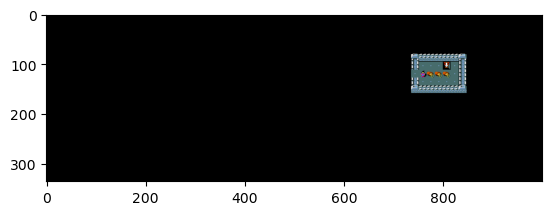

In [9]:
def bonusroom():
    lvl=LevelGenerator(lit=True,flags=['premapped'],map=bonusroommap)
    lvl.set_start_pos((21,2))
    lvl.add_stair_down(place=(24,1))
    lvl.add_line("GOLD: 5,(22,2)")
    lvl.add_line("GOLD: 5,(23,2)")
    lvl.add_line("GOLD: 5,(24,2)")
    
    return lvl.get_des()

render_des_file(bonusroom())


Boss room: a room with a boss and 20 gold of reward for its death.


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                              -----                             
                                              |.>.|                             
                                              |...|                             
                                        --------.----                           
                                        |...|.......|                           
                                        |...|.......|----                       
                           

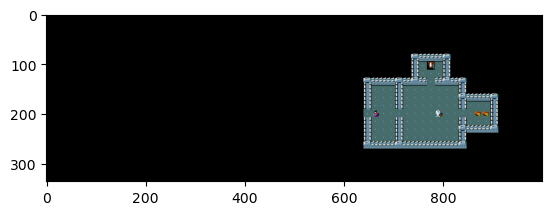

In [10]:
def bossroomdes(levelnumber):
    lvl=LevelGenerator(map=bossmap,lit=True,flags=['premapped'])
    lvl.set_start_pos((21,7))
    lvl.add_stair_down(place=(28, 1))
    #lvl.add_door("closed", place=(28,3))
    #lvl.add_door("closed", place=(32,7))

    lvl.add_line("GOLD: 5,(34,7)")
    lvl.add_line("GOLD: 5,(35,6)")
    lvl.add_line("GOLD: 5,(35,7)")
    lvl.add_line("GOLD: 5,(35,8)")
    #AGGIUNGI IL BOSS (29,7)
    lvl.add_monster(name=BOSS[levelnumber-2],place=(29,7))
    
    return lvl.get_des()

render_des_file(bossroomdes(2))
render_des_file(bossroomdes(3))
render_des_file(bossroomdes(4))
render_des_file(bossroomdes(5))

Mini boss room: the room shown in the presentation, three Mobs defend the exit, one defends 5 gold and a Miniboss defends 15 gold.


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
                                            ------------                        
                                            |.........>|                        
                                            |.------...|                        
                                            |.|........|                        
                                            |.-----....|                        
                                            |.....|....|                        
                                            |------....|                        
                                            |..........|                        
                           

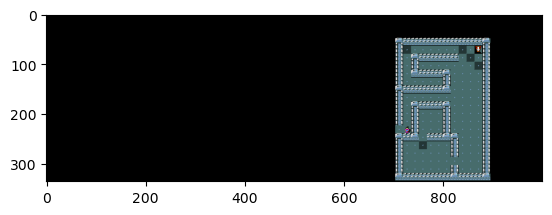

In [11]:
def minibossroomdes(levelnumber):
    lvl=LevelGenerator(map=minibossmap,lit=True,flags=['premapped'])
    lvl.set_start_pos((21,11))
    lvl.add_stair_down(place=(30, 1))
    
    #ZONA MOB
    lvl.add_monster(name=MOB[levelnumber-1],place=(28,1))
    lvl.add_monster(name=MOB[levelnumber-1],place=(29,2))
    lvl.add_monster(name=MOB[levelnumber-1],place=(30,3))
    #lvl.add_door("closed", place=(27,1))
    lvl.add_monster(name=MOB[levelnumber-1],place=(21,1))
    lvl.add_line("GOLD: 5,(25,5)")


    #ZONA MINIBOSS
    lvl.add_monster(name=MINIBOSS[levelnumber-2],place=(23,13))
    #lvl.add_door("closed", place=(23,12))
    #lvl.add_door("closed", place=(27,15))
    #MINIBOSS REWARD
    lvl.add_line("GOLD: 5,(23,10)")
    lvl.add_line("GOLD: 5,(24,10)")
    lvl.add_line("GOLD: 5,(25,10)")
    return lvl.get_des()

render_des_file(minibossroomdes(2))
render_des_file(minibossroomdes(3))
render_des_file(minibossroomdes(4))


Common room: room without obstacles, Mob and gold are randomly distributed.


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                          ---------------                       
                                          |..........B.>|                       
                                          |.$...........|                       
                                          |......B......|                       
                                          |.............|                       
                                          |....B........|                       
                           

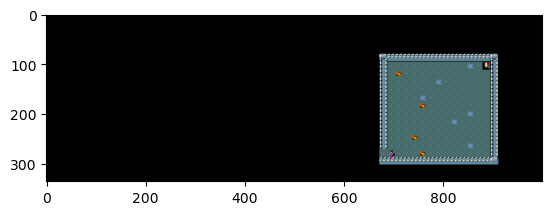

In [12]:
def roomroomdes(seed,levelnumber):
    lvl=LevelGenerator(map=roommap,lit=True,flags=['premapped'])
    lvl.set_start_pos((21,12))
    lvl.add_stair_down(place=(33, 1))
    random.seed(seed)

    #MUTUALLY EXCLUSIVE RANDOMNESS----- 
    pseudoarray=[]
    for i in range(1,13):
        pseudoarray.append(i)
    pseudomatrix=[]
    for i in range(0,10):
        pseudomatrix.append(pseudoarray)
    temporaryseed=seed
    def pseudorandompos (seed:(int))->(int,int):
        random.seed(seed)
        a=random.randint(0,9)
        b=random.choice(pseudomatrix[a])
        pseudomatrix[a].pop(pseudomatrix[a].index(b))
        return (a+22,b)
    #-------------------------------    

    for i in range(0,4):
        lvl.add_line("GOLD: 5,"+str(pseudorandompos(temporaryseed)))
        temporaryseed=temporaryseed+1

    for i in range(0,6):
        lvl.add_monster(name=MOB[levelnumber-1],place=pseudorandompos(temporaryseed))
        temporaryseed=temporaryseed+1
  
    return lvl.get_des()

render_des_file(roomroomdes(1,1))
render_des_file(roomroomdes(1,2))
render_des_file(roomroomdes(1,3))
render_des_file(roomroomdes(1,4))




Maze Room: Pathfinding in a small Labirinth with three Mobs in movement randomly. At the end of the level there are 15 gold as reward.


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                    ---                   ---                   
                                    |.                     .|                   
                                    |.... ... ... ... ......|                   
                                    |.. . . . . . . . .   ..|                   
                                    .@. ... ... . . . ... .>|                   
                                    |.          . .     . ..|                   
                           

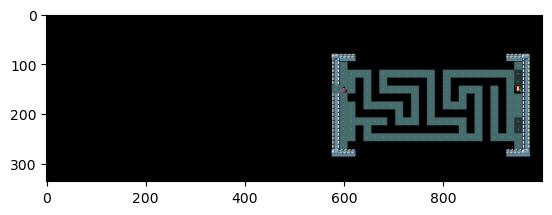

In [13]:

def mazeroomdes(levelnumber):
    lvl=LevelGenerator(map=mazebasemap,lit=True,flags=['premapped'])
    lvl.set_start_pos((21,4))

    lvl.add_stair_down(place=(43, 4))
    
    lvl.add_mazewalk(coord=(21,4), dir='east')

    lvl.add_monster(MOB[levelnumber-1],place=(43,3))
    lvl.add_monster(MOB[levelnumber-1],place=(43,2))
    lvl.add_monster(MOB[levelnumber-1],place=(43,8))
    lvl.add_monster(MOB[levelnumber-1],place=(43,9))

    lvl.add_line("GOLD: 5,(43,5)")
    lvl.add_line("GOLD: 5,(43,6)")
    lvl.add_line("GOLD: 5,(43,7)")
 
    return lvl.get_des()


render_des_file(mazeroomdes(2))
render_des_file(mazeroomdes(3))
render_des_file(mazeroomdes(4))


  
Common Room = 50% | Miniboss Room = 30% | Boss Room = 10% | Maze Room = 9,5% | Bonus Room=0,5%  
In the first level is guaranteed a Room, in the last a Boss Room, for the others the previous probabilities are followed. 



In [14]:
def creabattlefield(levelnumber:int ,startingseed:int ):
    if levelnumber==1:
        return roomroomdes(startingseed, levelnumber)
    elif levelnumber==5:
        return bossroomdes(5)
    else:
        random.seed(startingseed*levelnumber)
        choice=random.randint(0,200)
        if(choice<=100):
            return roomroomdes(startingseed,levelnumber)
        elif(choice<=160):
            return minibossroomdes(levelnumber)
        elif(choice<=180):
            return bossroomdes(levelnumber)
        elif(choice<=199):
            return mazeroomdes(levelnumber)
        else:
            return bonusroom
    
creabattlefield(1,1)

'\nMAZE: "mylevel", \' \'\nFLAGS:premapped\nINIT_MAP: solidfill,\' \'\nGEOMETRY:center,center\nMAP\n                    |||||||||||||||\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    ..............|\n                    |||||||||||||||\nENDMAP\nREGION:(0,0,35,14),lit,"ordinary"\nBRANCH:(21,12,21,12),(20,11,20,11)\nSTAIR:(33, 1),down\nGOLD: 5,(24, 10)\nGOLD: 5,(22, 2)\nGOLD: 5,(25, 12)\nGOLD: 5,(25, 6)\nMONSTER:"bat",(31, 7)\nMONSTER:"bat",(31, 11)\nMONSTER:"bat",(27, 3)\nMONSTER:"bat",(25, 5)\nMONSTER:"bat",(29, 8)\nMONSTER:"bat",(31, 1)\n'

In the last part of the level generation notebook we are going to merge the generated shop, to the generated battlefield to obtain the des file of the completed level.  
The required arguments are the level number and a seed (from 0 to 200).

In [15]:
def takemap(desfile: str):
    dessplittato=desfile.split('\n')
    j=0
    for i in dessplittato:
        if i=="MAP":
            break
        else:
            j=j+1
    dessplittato=dessplittato[j+1:]
    l=0
    for k in dessplittato:
        if k=="ENDMAP":
            break
        else:
            l=l+1
    dessplittato=dessplittato[:l]
    return '\n'.join(dessplittato)

def mapmerger(shopmap:str,bfdmap:str):
    cleanbfd=(bfdmap)
    cleanbfdlist=cleanbfd.split('\n')
    cleanlines=[]
    for i in cleanbfdlist:
        cleanlines.append(i[18:])
    cleanshop=(shopmap)
    cleanshoplist=cleanshop.split('\n')
    cleanlen=cleanshoplist.__len__()
    finalmap=[]
    k=0
    for j in cleanlines:
        if k<cleanlen:
            finalmap.append(cleanshoplist[k]+j)
        else:
            finalmap.append("                  "+j)
        k=k+1
    cleanlines=[]
    return('\n'.join(finalmap))


print(mapmerger(takemap(creashop(1,1)),takemap(bonusroom())))
print('\n\n\n')
print(mapmerger(takemap(creashop(2,2)),takemap(bossroomdes(2))))
print('\n\n\n')
print(mapmerger(takemap(creashop(3,2)),takemap(minibossroomdes(3))))
print('\n\n\n')
print(mapmerger(takemap(creashop(4,2)),takemap(roomroomdes(2,4))))
print('\n\n\n')
print(mapmerger(takemap(creashop(4,2)),takemap(roomroomdes(2,4))))

||||||||||||||||    |||||||
|...............    |.....|
|...........||||    ......|
|...........|       |.....|
|...........|       |||||||
|...........|              
|...........|              
|||||||||||||              
                           
                           
                           




||||||||||||||||          |||||      
|...............          |...|      
|...........||||          |...|      
|...........|       ||||||||.||||    
|...........|       |...|.......|    
|...........|       |...|.......|||||
|...........|       |...|.......|...|
|||||||||||||       ................|
                    |...|.......|...|
                    |...|.......|||||
                    |...|.......|    
                    |||||||||||||    




||||||||||||||||    ||||||||||||
|...............    |..........|
|...........||||    |.||||||...|
|...........|       |.|........|
|...........|       |.|||||....|
|...........|       |.....|....|
|...........|       |||||||...

Dopo aver unito le mappe estraiamo il branch dal battlefield, lo utilizziamo com destinazione del portal e otteniamo la mappa finale.


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                    ----------------          -----                             
                    |.....@.....+...          |.>.|                             
                    |...........|--.          |...|                             
                    |..!.).).[..|  .    --------.----                           
                    |......)....|  .    |...|.......|                           
                    |......)....|  .    |...|.......|----                       
                    |@.....

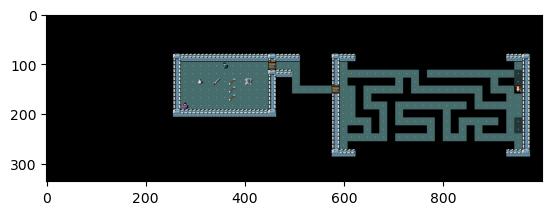

In [16]:

def incomingextractor(bfddes:str)->(str,(int,int)):
    bfdsplitted=bfddes.split('\n')
    for i in bfdsplitted:
        if "BRANCH" in i:
            branchsplittato=(i[7:].split(','))
            portalx=branchsplittato[2]
            portaly=branchsplittato[1]
            bfdsplitted.pop(bfdsplitted.index(i))
            return(('\n'.join(bfdsplitted)),(int(portalx)-1,int(portaly)))

def headerextractor(desfile:str): 
    dessplitted=desfile.split('\n')
    k=0
    for j in dessplitted:
        if "ENDMAP" in j:
            break
        else:
            k=k+1
    finale="\n".join(dessplitted[k+1:])
    return finale

def completemapdes(levelnumber,startingseed,custom=None):
    if custom==None:
        battlefield=creabattlefield(levelnumber,startingseed)
    elif custom=="boss":
        battlefield=bossroomdes(levelnumber)
    elif custom=="miniboss":
        battlefield=minibossroomdes(levelnumber)
    elif custom=="room":
        battlefield=roomroomdes(startingseed,levelnumber)
    elif custom=="maze":
        battlefield=mazeroomdes(levelnumber)
    elif custom=="bonus":
        battlefield=bonusroom()
    else:
        print("choosen a wrong custom map")
        return None

    portal=incomingextractor(battlefield)
    battlefield=portal[0]
    incominglocation=portal[1]
    battlefieldheader=headerextractor(battlefield)
    shop=creashop(levelnumber,startingseed)
    shopheader=headerextractor(shop)
    lvl=LevelGenerator(map=mapmerger(takemap(shop),takemap(battlefield)),lit=True,flags=['premapped'])
    lvl.add_line(shopheader)
    lvl.add_line(battlefieldheader)
    lvl.add_door("closed", place=incominglocation)
    lvl.fill_terrain("rect",".",15,1,15,incominglocation[1])
    lvl.fill_terrain("rect",".",15,incominglocation[1],incominglocation[0]-1,incominglocation[1])
    return lvl.get_des()





render_des_file(completemapdes(3,28,"boss"))
render_des_file(completemapdes(3,28,"miniboss"))

render_des_file(completemapdes(3,28,"bonus"))
render_des_file(completemapdes(3,28,"room"))
render_des_file(completemapdes(3,28,"maze"))



IN ORDER TO CREATE A NEW VALID DES CALL: completemapdes(1,20)
IF A SPECIFIC TYPE OF LEVEL IS REQUIRED ADD THE ARGUMENT ("room","maze","boss","miniboss","bonus") AS THE LAST ARGUMENT
